資料清理完成，總數: 8040
資料準備完成。

---  GDA 分類模型: ---
訓練 GDA 模型並評估效能...
GDA 分類準確率: 0.5568

GDA 分類報告:
               precision    recall  f1-score   support

           0       0.56      0.98      0.72      1372
           1       0.00      0.00      0.00      1040

    accuracy                           0.56      2412
   macro avg       0.28      0.49      0.36      2412
weighted avg       0.32      0.56      0.41      2412



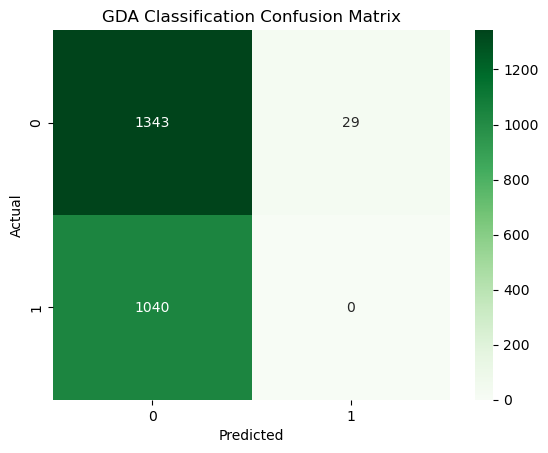

 繪製 GDA 決策邊界...


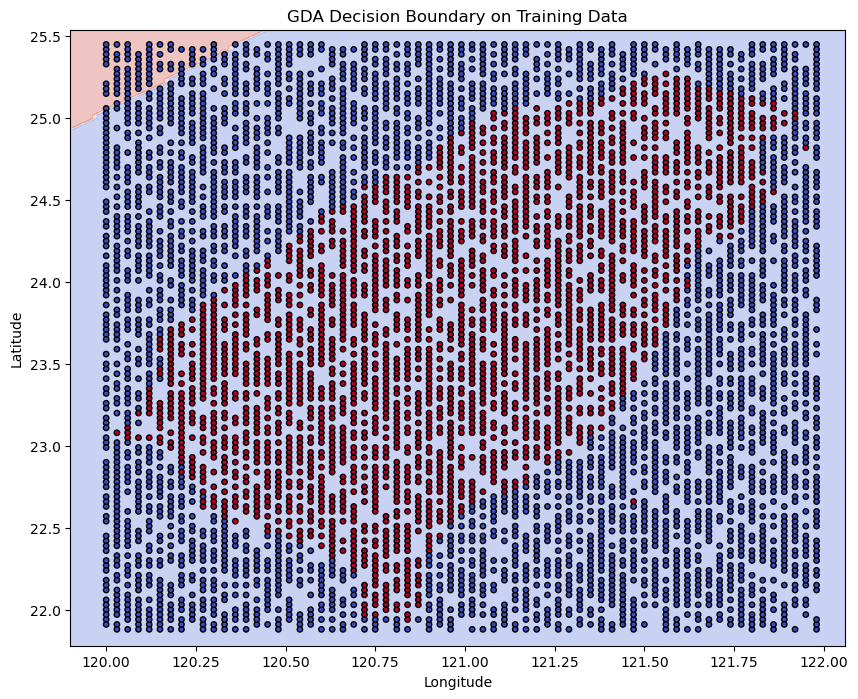

GDA 部分完成。

---  組合迴歸模型: ---
訓練迴歸模型 R(x) (KNeighborsRegressor)...
組合函數 h(x)...
組合函數 h(x) 已定義。
 應用組合模型

組合模型行為展示 (前 15 筆資料):
      longitude  latitude  C(x)_GDA_Prediction  h(x)_Final_Output
2835     120.63     23.14                    0             -999.0
737      120.00     22.21                    0             -999.0
3334     121.53     23.35                    0             -999.0
7386     120.48     25.18                    0             -999.0
1373     120.99     22.48                    0             -999.0
5628     120.00     24.40                    0             -999.0
5574     120.39     24.37                    0             -999.0
453      121.53     22.06                    0             -999.0
7688     121.50     25.30                    0             -999.0
3467     121.50     23.41                    0             -999.0
4769     120.36     24.01                    0             -999.0
6255     120.72     24.67                    0             -999.0
6739     121.17    

C:\Users\maggi\anaconda3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [5]:
import os
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from mpl_toolkits.mplot3d import Axes3D


folder_path = r'C:\Users\maggi\Downloads\ML\Weather' 
file_name = 'O-A0038-003.xml'

full_path = os.path.join(folder_path, file_name)

nx = 67
ny = 120

tree = ET.parse(full_path)
root = tree.getroot()
ns = 'urn:cwa:gov:tw:cwacommon:0.1'

content_text = None
for content in root.findall(f'.//{{{ns}}}Content'):
    if content.text and "," in content.text:
        content_text = content.text
        break
if content_text is None:
    raise ValueError("找不到有效的 <Content> 區塊!")


clean_text = content_text.replace("\n", "").strip()
clean_text = re.sub(r'(E[+-]\d{2})(-)', r'\1,\2', clean_text)
numbers = [float(item) for item in clean_text.split(",") if item.strip() != ""]

if len(numbers) != nx * ny:
    raise ValueError(f"資料大小 ({len(numbers)}) 與網格 ({ny}x{nx}) 不符!")

print("資料清理完成，總數:", len(numbers))


values_grid = np.array(numbers).reshape(ny, nx)
lon_start, lat_start, step = 120.0, 21.88, 0.03
lon_list = [lon_start + i*step for i in range(nx)]
lat_list = [lat_start + i*step for i in range(ny)]
lon_grid, lat_grid = np.meshgrid(lon_list, lat_list)
df = pd.DataFrame({
    'longitude': lon_grid.flatten(),
    'latitude': lat_grid.flatten(),
    'value': values_grid.flatten()
})


df_class = df.copy()
df_class['label'] = (df_class['value'] != -999.0).astype(int)
df_reg = df[df['value'] != -999.0].copy()


X_class = df_class[['longitude', 'latitude']]
y_class = df_class['label']
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_class, y_class, test_size=0.3, random_state=42)

X_reg = df_reg[['longitude', 'latitude']]
y_reg = df_reg['value']
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)

print("資料準備完成。\n")


print("---  GDA 分類模型: ---")


class GDA:
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)

        # 計算參數: phi, mu, sigma
        self.phi = np.zeros(n_classes)
        self.mu = np.zeros((n_classes, n_features))
        sigma = np.zeros((n_features, n_features))

        for idx, c in enumerate(self.classes):
            X_c = X[y == c]
            self.phi[idx] = X_c.shape[0] / n_samples
            self.mu[idx, :] = np.mean(X_c, axis=0)
            sigma += (X_c - self.mu[idx, :]).T @ (X_c - self.mu[idx, :])

        self.sigma = sigma / n_samples
        self.inv_sigma = np.linalg.inv(self.sigma)

    def predict(self, X):
        
        log_posteriors = []
        for idx, c in enumerate(self.classes):
            prior = np.log(self.phi[idx])
            
            likelihood_term = -0.5 * np.sum((X - self.mu[idx, :]) @ self.inv_sigma * (X - self.mu[idx, :]), axis=1)
            log_posteriors.append(prior + likelihood_term)
        
        predictions_idx = np.argmax(np.array(log_posteriors).T, axis=1)
        return self.classes[predictions_idx]


print("訓練 GDA 模型並評估效能...")
gda_model = GDA()
gda_model.fit(Xc_train.to_numpy(), yc_train.to_numpy())
yc_pred_gda = gda_model.predict(Xc_test.to_numpy())
accuracy_gda = accuracy_score(yc_test, yc_pred_gda)

print(f"GDA 分類準確率: {accuracy_gda:.4f}")
print("\nGDA 分類報告:\n", classification_report(yc_test, yc_pred_gda))

cm_gda = confusion_matrix(yc_test, yc_pred_gda)
sns.heatmap(cm_gda, annot=True, fmt='d', cmap='Greens')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("GDA Classification Confusion Matrix")
plt.show()


print(" 繪製 GDA 決策邊界...")
def plot_decision_boundary(X, y, model, title):
    X_np, y_np = X.to_numpy(), y.to_numpy()
    x_min, x_max = X_np[:, 0].min() - 0.1, X_np[:, 0].max() + 0.1
    y_min, y_max = X_np[:, 1].min() - 0.1, X_np[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, cmap='coolwarm', s=15, edgecolor='k')
    plt.title(title)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

plot_decision_boundary(Xc_train, yc_train, gda_model, "GDA Decision Boundary on Training Data")
print("GDA 部分完成。\n")


print("---  組合迴歸模型: ---")


print("訓練迴歸模型 R(x) (KNeighborsRegressor)...")
knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(Xr_train, yr_train) 


print("組合函數 h(x)...")
def combined_model(X_input, classification_model, regression_model):
    
    X_input_np = X_input.to_numpy() if isinstance(X_input, pd.DataFrame) else X_input
    
    
    class_preds = classification_model.predict(X_input_np)
    reg_preds = regression_model.predict(X_input_np)
    
    
    h_x_output = np.full(X_input_np.shape[0], -999.0)
    is_class_1 = (class_preds == 1)
    h_x_output[is_class_1] = reg_preds[is_class_1]
    
    return h_x_output

print("組合函數 h(x) 已定義。")


print(" 應用組合模型")


h_predictions = combined_model(Xc_test, gda_model, knn_reg)


results_df = pd.DataFrame({
    'longitude': Xc_test['longitude'],
    'latitude': Xc_test['latitude'],
    'C(x)_GDA_Prediction': gda_model.predict(Xc_test.to_numpy()),
    'h(x)_Final_Output': h_predictions
})
print("\n組合模型行為展示 (前 15 筆資料):")
print(results_df.head(15).round(2))


